In [1]:
import matplotlib.pyplot as plt
from helpers import *
import pickle
torch.set_printoptions(precision=2,sci_mode=False, linewidth=200)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)
loss_fn = nn.BCELoss()

Using device: cpu


## Data Model and Learners

In [2]:
n_points = 400
n_features = 12
n_train_sets = 20
n_test_trials = 20
print("n_points:", n_points)
print("n_features:", n_features)

# Fix the variance to 1/n_features.
sig_sq = 1.0/n_features

# dist_sd_ratio = K, where norm(u-v) = K*sigma.
dist_sd_ratios = np.logspace(-1, .05 + .5*np.log(np.log(n_points)), num=50)
# dist_sd_ratios = np.linspace(1./10., 1.2*np.log(n_points), num=100)
data_model = {}
p = .5
q = .1
for K in dist_sd_ratios:
    data_model[K] = XCSBM(n_points, n_features, K, sig_sq, p, q)

# Learning models.
learners = {
    'mlp': {}, # 2 layer MLPs
    'gcn2l10': {}, # 2 layer GCN with 1 GC at layer 1
    'gcn2l01': {}, # 2 layer GCN with 1 GC at layer 2
}

n_points: 400
n_features: 12


## Training

In [3]:
epochs = 1000

train_acc = {}
train_acc_std = {}
train_loss = {}
train_loss_std = {}

# Fix network architectures for the networks.
channels_2l = [[n_features, 4], [4, 1]]

for model_type in learners:
    train_acc[model_type] = []
    train_acc_std[model_type] = []
    train_loss[model_type] = []
    train_loss_std[model_type] = []
    for K in dist_sd_ratios:
        learners[model_type][K] = []

for K in dist_sd_ratios:
    for i in range(n_train_sets):
        learners['mlp'][K].append(MLP(n_layers=2, n_features=n_features, channels=channels_2l))
        learners['gcn2l10'][K].append(GCN(n_layers=2, n_features=n_features, convolutions=[1, 0], channels=channels_2l))
        learners['gcn2l01'][K].append(GCN(n_layers=2, n_features=n_features, convolutions=[0, 1], channels=channels_2l))

print('Training', len(dist_sd_ratios), 'MLP and GCN models...')

for (j, K) in enumerate(dist_sd_ratios):
    for model_type in learners:
        acc_list = torch.zeros(n_train_sets)
        loss_list = torch.zeros(n_train_sets)
        data = data_model[K].generate_data().to(device)
        for t in range(n_train_sets):
            print('\rTraining ' + str(j+1) + '.' + str(t+1) +  '/' + str(len(dist_sd_ratios)) + '.' + str(n_train_sets), model_type, 'models...', end='\r')
            learner = learners[model_type][K][t].to(device)
            set_params(learner, data_model[K], n_layers=learner.n_layers, device=device)
            train_model(learner, data, loss_fn, lr=0.01, epochs=epochs)
            learner.eval()
            pred = learner(data)
            acc_list[t] = accuracy(pred, data.y).item()
            loss_list[t] = loss_fn(pred, data.y.float()).item()
        
        train_acc[model_type].append(acc_list.mean().item())
        train_acc_std[model_type].append(acc_list.std(unbiased=False).item())
        train_loss[model_type].append(loss_list.mean().item())
        train_loss_std[model_type].append(loss_list.std(unbiased=False).item())

print('\nTraining complete.')

Training 50 MLP and GCN models...
Training 50.20/50.20 gcn2l01 models...
Training complete.


## Evaluation

In [4]:
test_acc = {}
test_acc_std = {}
test_loss = {}
test_loss_std = {}
    
for model_type in learners:
    test_acc[model_type] = []
    test_acc_std[model_type] = []
    test_loss[model_type] = []
    test_loss_std[model_type] = []
    for (j, K) in enumerate(dist_sd_ratios):
        print('\rEvaluating', j+1, '/', len(dist_sd_ratios), model_type, 'models...', end='')
        avg_acc_list = torch.zeros(n_test_trials)
        avg_loss_list = torch.zeros(n_test_trials)
        for tt in range(n_test_trials):
            data = data_model[K].generate_data().to(device)
            acc_list = torch.zeros(n_train_sets)
            loss_list = torch.zeros(n_train_sets)
            for ts in range(n_train_sets):
                learner = learners[model_type][K][ts].to(device)
                pred = learner(data)
                acc_list[ts] = accuracy(pred, data.y).item()
                loss_list[ts] = loss_fn(pred, data.y.float()).item()
            
            avg_acc_list[tt] = acc_list.mean().item()
            avg_loss_list[tt] = loss_list.mean().item()

        test_acc[model_type].append(avg_acc_list.mean().item())
        test_acc_std[model_type].append(avg_acc_list.std(unbiased=False).item())
        test_loss[model_type].append(avg_loss_list.mean().item())
        test_loss_std[model_type].append(avg_loss_list.std(unbiased=False).item())

print('\nEvaluation complete.')

Evaluating 50 / 50 gcn2l01 models...
Evaluation complete.


## Plotting helpers

In [13]:
line_wd = 2 # line width for plots.
marker_sz = 7 # marker size for plots.
labels = {
    'mlp': 'MLP',
    'gcn2l10': 'GCN 2 layers 1 conv at layer 1',
    'gcn2l01': 'GCN 2 layers 1 conv at layer 2',
}

def plot_with_std(ax, x, y, yerr, label):
    y = np.asarray(y)
    yerr = np.asarray(yerr)
    ax.plot(x, y, linewidth=line_wd, linestyle= '-', marker='.', markersize=marker_sz, label=label)
    ax.fill_between(x, y - yerr, y + yerr, alpha=0.2)

# for model_type in learners:
#     for i in range(1, len(dist_sd_ratios)-1):
#         train_loss[model_type][i] = (train_loss[model_type][i-1] + train_loss[model_type][i] + train_loss[model_type][i+1])/3.
#         test_loss[model_type][i] = (test_loss[model_type][i-1] + test_loss[model_type][i] + test_loss[model_type][i+1])/3.
#         train_acc[model_type][i] = (train_acc[model_type][i-1] + train_acc[model_type][i] + train_acc[model_type][i+1])/3.
#         test_acc[model_type][i] = (test_acc[model_type][i-1] + test_acc[model_type][i] + test_acc[model_type][i+1])/3.

## Plot loss

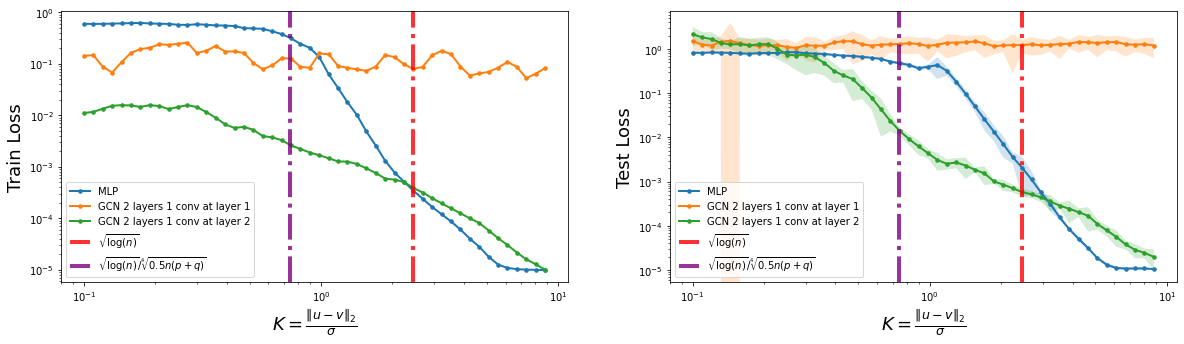

In [14]:
fig = plt.figure(figsize=(20,5), facecolor=[1,1,1])
gs = fig.add_gridspec(1, 2, hspace=0)
axs = gs.subplots()
for i in range(2):
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')

axs[0].set_ylabel(r'Train Loss', fontsize=18)
axs[1].set_ylabel(r'Test Loss', fontsize=18)
    
# Plot the training and test losses for each model.
for model_type in labels:
    plot_with_std(axs[0], dist_sd_ratios, train_loss[model_type], train_loss_std[model_type], labels[model_type])
    plot_with_std(axs[1], dist_sd_ratios, test_loss[model_type], test_loss_std[model_type], labels[model_type])

for i in range(2):
    axs[i].axvline(x=np.sqrt(np.log(n_points)), color='red', linewidth=4, linestyle='-.', alpha=.8, label=r'$\sqrt{\log(n)}$')
    axs[i].axvline(
        x=np.sqrt(np.log(n_points)/np.sqrt(.5*n_points*(p+q))),
        color='purple', linewidth=4, linestyle='-.', alpha=.8,
        label=r'$\sqrt{\log(n)}/\sqrt[4]{0.5n(p+q)}$')
    axs[i].set_xlabel(r'$K = \frac{\Vert u-v \Vert_2}{\sigma}$', fontsize=18)
    axs[i].legend()
fig.savefig("figures/synthetic_data_gcn_conv_layer1_loss.pdf", dpi=400, bbox_inches='tight')

## Plot accuracy

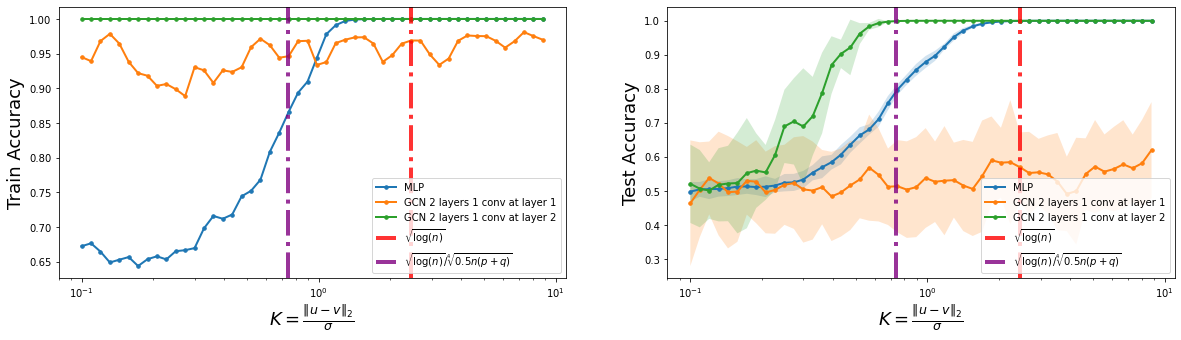

In [15]:
fig = plt.figure(figsize=(20,5), facecolor=[1,1,1])
gs = fig.add_gridspec(1, 2, hspace=0)
axs = gs.subplots()
for i in range(2):
    axs[i].set_xscale('log')

axs[0].set_ylabel(r'Train Accuracy', fontsize=18)
axs[1].set_ylabel(r'Test Accuracy', fontsize=18)
    
# Plot the training and test losses for each model.
for model_type in labels:
    plot_with_std(axs[0], dist_sd_ratios, train_acc[model_type], train_acc_std[model_type], labels[model_type])
    plot_with_std(axs[1], dist_sd_ratios, test_acc[model_type], test_acc_std[model_type], labels[model_type])

for i in range(2):
    axs[i].axvline(x=np.sqrt(np.log(n_points)), color='red', linewidth=4, linestyle='-.', alpha=.8, label=r'$\sqrt{\log(n)}$')
    axs[i].axvline(
        x=np.sqrt(np.log(n_points)/np.sqrt(.5*n_points*(p+q))),
        color='purple', linewidth=4, linestyle='-.', alpha=.8,
        label=r'$\sqrt{\log(n)}/\sqrt[4]{0.5n(p+q)}$')
    axs[i].set_xlabel(r'$K = \frac{\Vert u-v \Vert_2}{\sigma}$', fontsize=18)
    axs[i].legend()
fig.savefig("figures/synthetic_data_gcn_conv_layer1_acc.pdf", dpi=400, bbox_inches='tight')

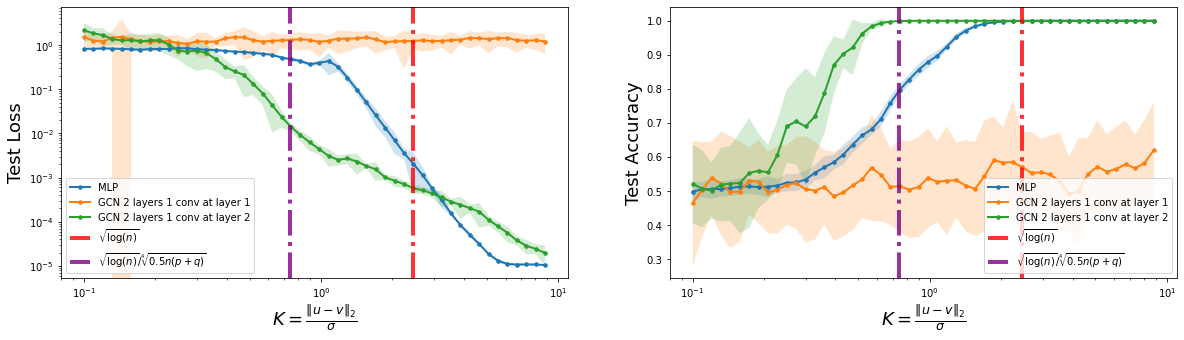

In [16]:
fig = plt.figure(figsize=(20,5), facecolor=[1,1,1])
gs = fig.add_gridspec(1, 2, hspace=0)
axs = gs.subplots()
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')

axs[0].set_ylabel(r'Test Loss', fontsize=18)
axs[1].set_ylabel(r'Test Accuracy', fontsize=18)
    
# Plot the training and test losses for each model.
for model_type in labels:
    plot_with_std(axs[0], dist_sd_ratios, test_loss[model_type], test_loss_std[model_type], labels[model_type])
    plot_with_std(axs[1], dist_sd_ratios, test_acc[model_type], test_acc_std[model_type], labels[model_type])

for i in range(2):
    axs[i].axvline(x=np.sqrt(np.log(n_points)), color='red', linewidth=4, linestyle='-.', alpha=.8, label=r'$\sqrt{\log(n)}$')
    axs[i].axvline(
        x=np.sqrt(np.log(n_points)/np.sqrt(.5*n_points*(p+q))),
        color='purple', linewidth=4, linestyle='-.', alpha=.8,
        label=r'$\sqrt{\log(n)}/\sqrt[4]{0.5n(p+q)}$')
    axs[i].set_xlabel(r'$K = \frac{\Vert u-v \Vert_2}{\sigma}$', fontsize=18)
    axs[i].legend()
fig.savefig("figures/synthetic_data_gcn_conv_layer1_test_loss_acc.pdf", dpi=400, bbox_inches='tight')